(1) Importing dependency

In [1]:
import sklearn
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import maxabs_scale

import librosa
from tqdm import tqdm_notebook as tqdm
import os
import os.path as path

import numpy as np
np.random.seed(13)
import random
random.seed(13)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, \
                                    BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
from tensorflow.keras.layers import (Conv1D, MaxPool1D, BatchNormalization, 
                                     GlobalAvgPool1D, Multiply, GlobalMaxPool1D,
                                     Dense, Dropout, Activation, Reshape, 
                                     Input, Concatenate, Add)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,4,5'

(2) Get Data

In [5]:
base_dir = 'data'
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [6]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [7]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [8]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
def se_fn(x, amplifying_ratio):
    num_features = x.shape[-1].value
    x = GlobalAvgPool1D()(x)
    x = Reshape((1, num_features))(x)
    x = Dense(num_features * amplifying_ratio, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Dense(num_features, activation='sigmoid', kernel_initializer='glorot_uniform')(x)
    return x


def basic_block(x, num_features, weight_decay, _):
    x = Conv1D(num_features, kernel_size=3, padding='same', use_bias=True,
               kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool1D(pool_size=3)(x)
    return x


def se_block(x, num_features, weight_decay, amplifying_ratio):
    x = basic_block(x, num_features, weight_decay, amplifying_ratio)
    x = Multiply()([x, se_fn(x, amplifying_ratio)])
    return x


def rese_block(x, num_features, weight_decay, amplifying_ratio):
    if num_features != x.shape[-1].value:
        shortcut = Conv1D(num_features, kernel_size=1, padding='same', use_bias=True,
                        kernel_regularizer=l2(weight_decay), kernel_initializer='glorot_uniform')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x
    x = Conv1D(num_features, kernel_size=3, padding='same', use_bias=True,
               kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Conv1D(num_features, kernel_size=3, padding='same', use_bias=True,
               kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    if amplifying_ratio > 0:
        x = Multiply()([x, se_fn(x, amplifying_ratio)])
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    x = MaxPool1D(pool_size=3)(x)
    return x

In [10]:
def resemul(input_shape, block_type='rese', multi=True, init_features=128, amplifying_ratio=16,
                drop_rate=0.5, weight_decay=0., num_classes=16):
    """Build a SampleCNN model.
    Args:
        batch_shape: A tensor shape including batch size (e.g. [23, 59049])
        block_type: A type of convolutional block among {se|rese|res|basic}
        multi: Whether to use multi-level feature aggregation.
        init_features: Number of feature maps of the first convolution.
        amplifying_ratio: Amplifying ratio of SE (not used for res and basic).
        weight_decay: L2 weight decay rate.
        drop_rate: Dropout rate.
        num_classes: Number of classes to predict.
    Returns:
        Keras Model.
    """
    if block_type == 'se':
        block = se_block
    elif block_type == 'rese':
        block = rese_block
    elif block_type == 'res':
        block = rese_block
        amplifying_ratio = -1
    elif block_type == 'basic':
        block = basic_block
    else:
        raise Exception('Unknown block type: ' + block_type)

    input_layer = Input(shape=input_shape)

    x = Conv1D(init_features, kernel_size=3, strides=3, padding='valid', use_bias=True,
                 kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_features = init_features
    layer_outputs = []
    for i in range(7):
        num_features *= 2 if (i == 2 or i == 6) else 1
        x = block(x, num_features, weight_decay, amplifying_ratio)
        layer_outputs.append(x)

    if multi:
        x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-3:]])
    else:
        x = GlobalMaxPool1D()(x)

    x = Dense(x.shape[-1].value, kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if drop_rate > 0.:
        x = Dropout(drop_rate)(x)
    x = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

In [11]:
model = resemul(input_shape=input_shape, num_classes=output_size)
model.summary()
model = multi_gpu_model(model, gpus=4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5333, 128)    512         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 5333, 128)    512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

(4) Compile 

In [12]:
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
              metrics=['accuracy'])

(5) Train

In [13]:
model_path = 'model/checkpoint/SampleCNN_RESE_SGD_checkpoint/'
os.makedirs(model_path, exist_ok=True)
model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [14]:
hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=10000, 
                 validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                 callbacks = [checkpointer, early_stopping])

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10000
36800/36805 [============================>.] - ETA: 0s - loss: 1.1545 - acc: 0.6462
Epoch 00001: val_loss improved from inf to 0.41933, saving model to model/checkpoint/SampleCNN_RESE_SGD_checkpoint/001-0.4193.hdf5
36805/36805 [==============================] - 154s 4ms/sample - loss: 1.1545 - acc: 0.6461 - val_loss: 0.4193 - val_acc: 0.8670
Epoch 2/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.4200 - acc: 0.8682
Epoch 00002: val_loss improved from 0.41933 to 0.24594, saving model to model/checkpoint/SampleCNN_RESE_SGD_checkpoint/002-0.2459.hdf5
36805/36805 [==============================] - 128s 3ms/sample - loss: 0.4203 - acc: 0.8681 - val_loss: 0.2459 - val_acc: 0.9215
Epoch 3/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.3094 - acc: 0.9021
Epoch 0

Epoch 25/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0506 - acc: 0.9831
Epoch 00025: val_loss did not improve from 0.08603
36805/36805 [==============================] - 130s 4ms/sample - loss: 0.0508 - acc: 0.9830 - val_loss: 0.0957 - val_acc: 0.9741
Epoch 26/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9835
Epoch 00026: val_loss did not improve from 0.08603
36805/36805 [==============================] - 129s 4ms/sample - loss: 0.0475 - acc: 0.9834 - val_loss: 0.0991 - val_acc: 0.9741
Epoch 27/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9853
Epoch 00027: val_loss did not improve from 0.08603
36805/36805 [==============================] - 129s 3ms/sample - loss: 0.0450 - acc: 0.9852 - val_loss: 0.0912 - val_acc: 0.9755
Epoch 28/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9853
Epoch 00028: val_loss did not improve from 0.08603
36805/36805 [

Epoch 55/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0587 - acc: 0.9805
Epoch 00055: val_loss did not improve from 0.08603
36805/36805 [==============================] - 127s 3ms/sample - loss: 0.0589 - acc: 0.9805 - val_loss: 0.1168 - val_acc: 0.9713
Epoch 56/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9885
Epoch 00056: val_loss did not improve from 0.08603
36805/36805 [==============================] - 128s 3ms/sample - loss: 0.0342 - acc: 0.9884 - val_loss: 0.0975 - val_acc: 0.9753
Epoch 57/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9874
Epoch 00057: val_loss did not improve from 0.08603
36805/36805 [==============================] - 129s 4ms/sample - loss: 0.0380 - acc: 0.9874 - val_loss: 0.0938 - val_acc: 0.9779
Epoch 58/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9907
Epoch 00058: val_loss did not improve from 0.08603
36805/36805 [

Epoch 85/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9904
Epoch 00085: val_loss did not improve from 0.08603
36805/36805 [==============================] - 128s 3ms/sample - loss: 0.0301 - acc: 0.9903 - val_loss: 0.1022 - val_acc: 0.9767
Epoch 86/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0181 - acc: 0.9938
Epoch 00086: val_loss did not improve from 0.08603
36805/36805 [==============================] - 128s 3ms/sample - loss: 0.0184 - acc: 0.9937 - val_loss: 0.1387 - val_acc: 0.9706
Epoch 87/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9885
Epoch 00087: val_loss did not improve from 0.08603
36805/36805 [==============================] - 128s 3ms/sample - loss: 0.0353 - acc: 0.9883 - val_loss: 0.1047 - val_acc: 0.9755
Epoch 88/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0233 - acc: 0.9920
Epoch 00088: val_loss did not improve from 0.08603
36805/36805 [

36800/36805 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9966
Epoch 00114: val_loss did not improve from 0.08603
36805/36805 [==============================] - 128s 3ms/sample - loss: 0.0109 - acc: 0.9965 - val_loss: 0.1023 - val_acc: 0.9769
Epoch 115/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9966
Epoch 00115: val_loss did not improve from 0.08603
36805/36805 [==============================] - 127s 3ms/sample - loss: 0.0118 - acc: 0.9965 - val_loss: 0.2372 - val_acc: 0.9550
Epoch 116/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9872
Epoch 00116: val_loss did not improve from 0.08603
36805/36805 [==============================] - 128s 3ms/sample - loss: 0.0403 - acc: 0.9871 - val_loss: 0.1027 - val_acc: 0.9767
Epoch 117/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9935
Epoch 00117: val_loss did not improve from 0.08603
36805/36805 [============

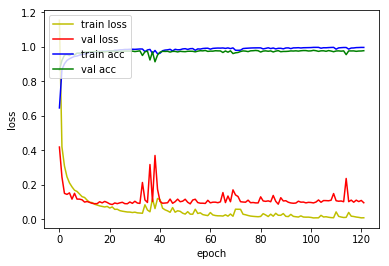

In [15]:
fig, ax = plt.subplots()
ax.plot(hist.history['loss'], 'y', label='train loss')
ax.plot(hist.history['val_loss'], 'r', label='val loss')
ax.plot(hist.history['acc'], 'b', label='train acc')
ax.plot(hist.history['val_acc'], 'g', label='val acc')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(loc='upper left')
plt.show()

png_path = 'visualization/learning_curve/'
filename = 'SampleCNN_RESE_SGD'+'.png'
os.makedirs(png_path, exist_ok=True)
fig.savefig(png_path+filename, transparent=True)

In [16]:
del model

(6) Test

In [17]:
model_path = 'model/checkpoint/SampleCNN_RESE_SGD_checkpoint/'
model_filename = model_path + sorted(os.listdir(model_path))[-1]
model = load_model(model_filename)
[loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
print('Loss:', loss, 'Accuracy:', accuracy)

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1271 - acc: 0.9674
Loss: 0.12708916977688145 Accuracy: 0.9673936


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
Y_pred = model.predict(x_test_abs)
y_pred = np.argmax(Y_pred, axis=1)

y_real = np.argmax(y_test_onehot, axis=1)

confusion_mat = confusion_matrix(y_real, y_pred)

print('Confusion Matrix')
print(confusion_mat)
print()

print('Classification Report')
print(classification_report(y_real, y_pred, target_names=y_table.T[0]))
print()

Confusion Matrix
[[373   0   4   0   3   0   0   3   0   2   0   0   0   0   0   0]
 [  1 348   0   0   4   2   0   0   0   4   1   4   0   0   0   0]
 [  3   0 379   1   1   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   3 358   2   0   1   0   1   0   0   2   0   0   0   9]
 [  0   1   0   0 363   1   0   0   0   1   0   1   0   0   1   0]
 [  0   1   0   2   5 396   0   0   2   1   1   0   0   0   0   0]
 [  0   0   1   3   1   1 365   1   1   0   0   1   0   0   0   0]
 [  1   0   1   1   2   0   0 366   1   0   3   1   0   0   0   0]
 [  0   0   4   3   0   0   0   0 359   4   2   3   0   0   0   1]
 [  0   2   0   0   0   4   0   0   0 369   0   2   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2 176   3   0   1   0   1]
 [  0   0   0   0   1   0   0   0   1   1   3 145   0   2   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0 165   1   0   1]
 [  0   0   4   0   0   0   0   2   0   0   1   1   0 184   0   0]
 [  0   0   0   0   0   1   0   1   1   0   0